In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
!nvidia-smi

Wed Dec  7 21:43:42 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    30W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#!pip install tensorflow-gpu

In [3]:
device_list = tf.test.gpu_device_name()
print(device_list)

/device:GPU:0


In [4]:
IM_SIZE = 224
CHANNELS = 3

In [ ]:
#! pip install split-folders

In [7]:
#%cd /content/drive/My Drive/Datascience projects

/content/drive/My Drive/Datascience projects


In [6]:
!pwd

/content/drive/MyDrive/Datascience projects


In [ ]:
#! split-folders --output train_val_test_Malaria_cell_images --ratio .6 .2 .2 -- Malaria_cell_images

Copying files: 27560 files [10:54, 42.08 files/s] 


In [8]:

train_gen= ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 10
)
train_ds = train_gen.flow_from_directory(
    'train_val_test_Malaria_cell_images/train',
     target_size = (IM_SIZE, IM_SIZE),
     batch_size = 32,
     #class_mode = 'categorical'
     class_mode = 'sparse'
     #shuffle = True
)


val_gen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 10
)
val_ds = val_gen.flow_from_directory(
    'train_val_test_Malaria_cell_images/val',
     target_size = (IM_SIZE, IM_SIZE),
     batch_size = 32,
     #class_mode = 'categorical'
     class_mode = 'sparse'
     #shuffle = True
)


test_gen = ImageDataGenerator(
     rescale = 1./255
)
test_ds = test_gen.flow_from_directory(
    'train_val_test_Malaria_cell_images/test',
     target_size = (IM_SIZE, IM_SIZE),
     batch_size = 32,
     #class_mode = 'categorical'
     class_mode = 'sparse'
)

Found 16534 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.
Found 5512 images belonging to 2 classes.


In [9]:
class_names = train_ds.class_indices
print(class_names)

{'Parasitized': 0, 'Uninfected': 1}


In [10]:
class_names = train_ds.class_indices.keys()
class_names = list(class_names)
print(class_names)

['Parasitized', 'Uninfected']


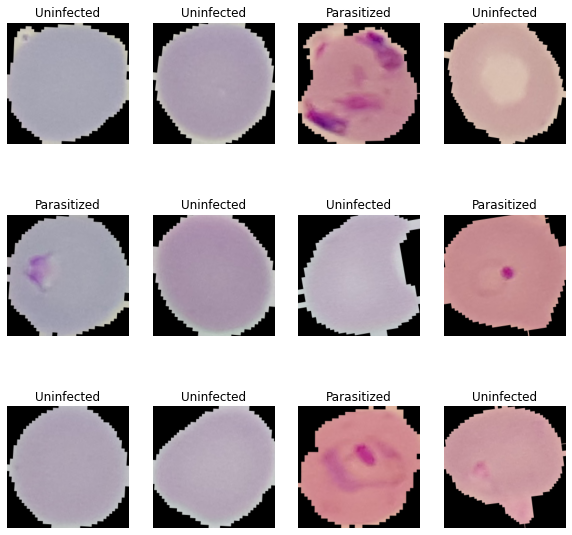

In [ ]:
plt.figure(figsize= (10,10))
for i in range (12):
  image, label = train_ds.next()
  ax = plt.subplot(3,4,i+1)
  #print(image.shape)
  plt.imshow(image[i])
  plt.title(class_names[int(label[i])]) # if class_mode = binary or sparse
  #plt.title(class_names[np.argmax(label[i])]) # if class_mode = categorical
  plt.show
  plt.axis("off")

In [ ]:
#print(label)

In [11]:
vgg19 = VGG19(input_shape=[IM_SIZE, IM_SIZE, CHANNELS], weights='imagenet', include_top=False )

80134624/80134624 [==============================] - 0s 0us/step


In [12]:
for layer in vgg19.layers:
  layer.trainable = False

In [13]:
vgg19.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
flatten = Flatten()(vgg19.output)

In [15]:
output = Dense(2, activation = 'softmax')(flatten)

In [16]:
model_vgg19 = Model(inputs = vgg19.input, outputs = output)

In [17]:
model_vgg19.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [18]:
model_vgg19.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'] )

In [19]:
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=8, 
    mode='max'
)

In [20]:
history_model_vgg19 = model_vgg19.fit(train_ds, epochs= 50, validation_data=val_ds, callbacks=[early_stopping])

Epoch 1/50
517/517 [==============================] - 5313s 10s/step - loss: 0.4027 - accuracy: 0.8301 - val_loss: 0.2663 - val_accuracy: 0.8882
Epoch 2/50
517/517 [==============================] - 295s 570ms/step - loss: 0.2625 - accuracy: 0.8946 - val_loss: 0.2666 - val_accuracy: 0.8955
Epoch 3/50
517/517 [==============================] - 299s 579ms/step - loss: 0.2266 - accuracy: 0.9082 - val_loss: 0.3016 - val_accuracy: 0.8857
Epoch 4/50
517/517 [==============================] - 300s 581ms/step - loss: 0.2472 - accuracy: 0.9042 - val_loss: 0.2205 - val_accuracy: 0.9182
Epoch 5/50
517/517 [==============================] - 299s 579ms/step - loss: 0.1984 - accuracy: 0.9242 - val_loss: 0.2056 - val_accuracy: 0.9240
Epoch 6/50
517/517 [==============================] - 297s 575ms/step - loss: 0.2002 - accuracy: 0.9240 - val_loss: 0.2299 - val_accuracy: 0.9214
Epoch 7/50
517/517 [==============================] - 295s 571ms/step - loss: 0.1994 - accuracy: 0.9261 - val_loss: 0.3410 - 

In [21]:
model_vgg19.evaluate(test_ds)

173/173 [==============================] - 1301s 8s/step - loss: 0.2414 - accuracy: 0.9207


[0.2414209544658661, 0.9207184314727783]

In [22]:
acc = history_model_vgg19.history['accuracy']
val_acc = history_model_vgg19.history['val_accuracy']

loss = history_model_vgg19.history['loss']
val_loss = history_model_vgg19.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

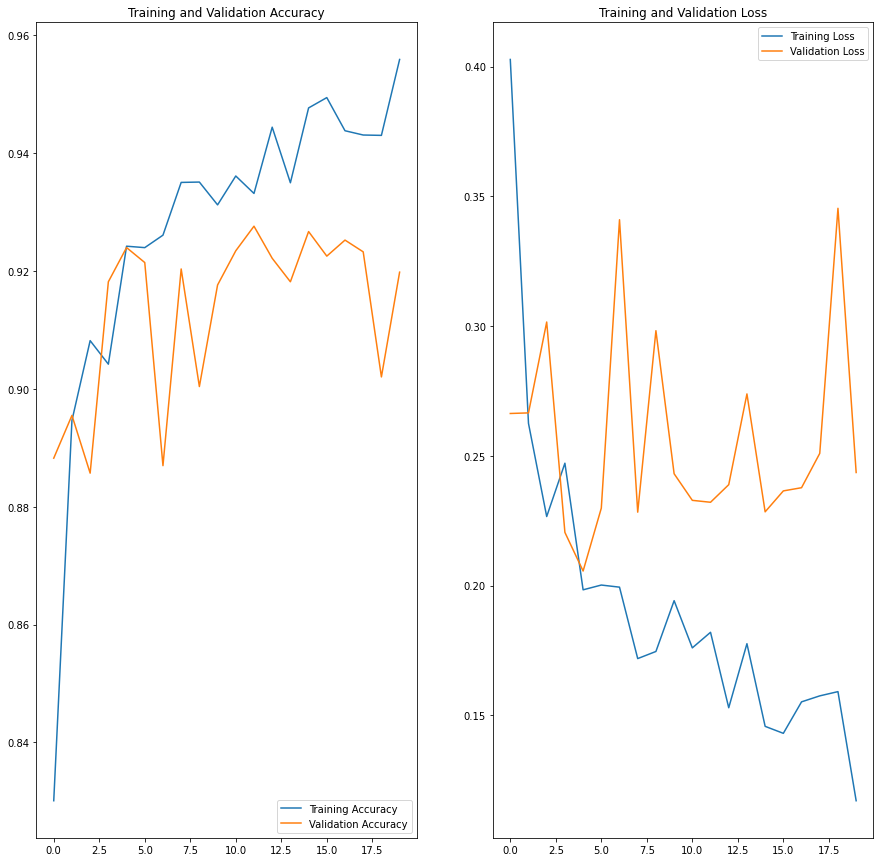

In [26]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.plot( acc, label = 'Training Accuracy')
plt.plot( val_acc, label = 'Validation Accuracy')
plt.legend(loc= 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot( loss, label = 'Training Loss')
plt.plot( val_loss, label = 'Validation Loss')
plt.legend(loc= 'upper right')
plt.title('Training and Validation Loss')


1/1 [==============================] - 0s 27ms/step


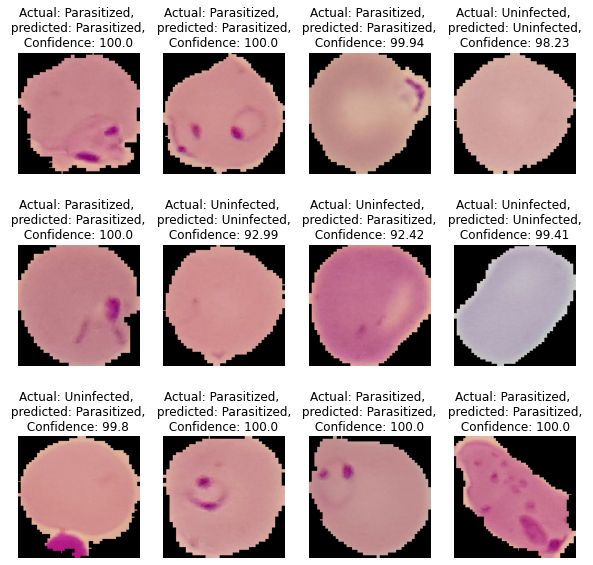

In [28]:
plt.figure(figsize=(10,10))
for images, labels in test_ds:
  for i in range (12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(images[i])

    actual_image= class_names[int(labels[i])] 
    #actual_image = class_names[np.argmax(labels[i])]
    predictions = model_vgg19.predict(images)
    predicted_image = class_names[np.argmax(predictions[i])] 
    confidence = round(100 * (np.max(predictions[i])), 2)

    plt.title(f"Actual: {actual_image}, \n predicted: {predicted_image}, \n Confidence: {confidence} ")
    plt.axis("off")

  break


In [33]:
model_vgg19.save("Saved_models_malaria/model_vgg19.h5")

In [34]:
#TODO: ROC curve, AUC, confusion matrix